# USDA Exploratory Data Analysis
- <b>Objective</b>: Exploratory Data Analysis on US Department of Agriculture Page Reports (Standard Reference 28)
---
### Contributor(s):
- Chris Burrows (<i> Bloomtech Data Scientist Student)</i>
---


### Reference Links:
- <a href='https://data.nal.usda.gov/dataset/composition-foods-raw-processed-prepared-usda-national-nutrient-database-standard-reference-release-28-0'>USDA SR28 Webpage</a>
- <a href='https://data.nal.usda.gov/system/files/sr28_doc.pdf'>USDA SR28 Documentation</a>
- <a href='https://data.nal.usda.gov/dataset/composition-foods-raw-processed-prepared-usda-national-nutrient-database-standard-referen-10'>USDA SR28 ASCII (Abbreviated) Dataset</a>
---
### Preface:
- <i>As a Data Scientist student, I ultimately chose this dataset because I have no technical experience in this field. This offered me a non-biased looked at the pure numerical findings. Although this lack of expertise indeed leads to a failure of strict correlational analysis, the compiled models present a compelling exploration of when classification is a superior method to regression.</i>
##### Last Update (11/9/2022)


In [1]:
#@title [/code] Google Colab
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    # !pip install category_encoders==2.*
    !pip install category_encoders
    !pip install pandas-profiling==2.*


In [2]:
#@title [/code] Import Packages
## Import Modules ##
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier, plot_tree ## ERRORS?
from sklearn.ensemble import RandomForestClassifier ## ERRORS?
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# I. Exploration - Stock Read Statement

In [3]:
#@title Dataset.info()
data_path = "/content/drive/MyDrive/Colab Notebooks/Custom_Data_Sets/USDA (Abbreviated) SR 28_CB_Subset_UTF.csv"
og_df = pd.read_csv(data_path)
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8790 non-null   int64  
 1   Shrt_Desc          8790 non-null   object 
 2   Water_(g)          8789 non-null   float64
 3   Energ_Kcal         8790 non-null   int64  
 4   Protein_(g)        8790 non-null   float64
 5   Lipid_Tot_(g)      8790 non-null   float64
 6   Ash_(g)            8465 non-null   float64
 7   Carbohydrt_(g)     8790 non-null   float64
 8   Fiber_TD_(g)       8196 non-null   float64
 9   Sugar_Tot_(g)      6958 non-null   float64
 10  Calcium_(mg)       8442 non-null   float64
 11  Iron_(mg)          8646 non-null   float64
 12  Magnesium_(mg)     8051 non-null   float64
 13  Phosphorus_(mg)    8211 non-null   float64
 14  Potassium_(mg)     8364 non-null   float64
 15  Sodium_(mg)        8707 non-null   float64
 16  Zinc_(mg)          8084 

In [4]:
#@title *Inspection 1: It seems like there are a few amount of rows with missing data?

empty_row_mask = og_df[og_df.isnull().any(axis=1)]

print(f'There are {empty_row_mask.shape[0]} rows with NaN (null) values in them...')

print(f'-- That is {100*(round(empty_row_mask.shape[0]/(len(og_df)), 2))}% of the data, leaving {round(len(og_df)*.25)} Usable rows!\n')

print("Given the nature of the columns... an imputation using the mean seems cumbersome...")

print(f'-- Train Set: {round((len(og_df)*.25) * .60)}, Validation Set: {round((len(og_df)*.25) * .20)}, Test Set: {round((len(og_df)*.25) * .20)} -- Not Enough Usable Data!!')

There are 6566 rows with NaN (null) values in them...
-- That is 75.0% of the data, leaving 2198 Usable rows!

Given the nature of the columns... an imputation using the mean seems cumbersome...
-- Train Set: 1318, Validation Set: 440, Test Set: 440 -- Not Enough Usable Data!!


In [5]:
#@title *Inspection 2: Dropping 75% of the rows seems a bit much. Perhaps we can identify columns with the most NaN values...
og_df['GmWt_2'].isnull().sum()             
empty_col_count = [og_df[col].isnull().sum() for col in og_df.columns
                  if og_df[col].isnull().sum() > 0]
percent_of_data = .10 # adjust this parameter to drop more or less columns...
empty_threshold = len(og_df) * percent_of_data
empty_max_cols = [col for col in og_df.columns
                  if og_df[col].isnull().sum() > empty_threshold]

print(f"There are {len(empty_col_count)} columns with NaN values... \n-- However, only " 
      f"{len(empty_max_cols)} columns have more than {empty_threshold}({percent_of_data*100}%) NaN values!! ")

There are 47 columns with NaN values... 
-- However, only 25 columns have more than 879.0(10.0%) NaN values!! 


In [6]:
#@title *Pandas Profile Report (pre-Wrangle)
Report = ProfileReport(og_df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/61 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
#@title [To Do: Seaborn Heatmap]

# II. Calculate Baseline Regression 

>  For our regression model, we've chosen to predict the amount of Vitamin C using the dataset. Our columns are full of NaN values that we could normally consider imputing with zeroes or the mean. However, we will **ultimately** take a different approach, because of the following note within the documentation:

**Per Documentation:** "If a value is not
present for any particular nutrient, that does not indicate that the value should be zero
or any other value—only that no value is available in SR."

> Let's look at what happens with our model when we impute with zeroes regardless. To do this, we will: 

*   Transform (or in this case, drop rather than encode) the object(categorical) columns
*   Impute the NaN values with zeroes








###1.) Wrangle

In [8]:
#@title Wrangle Function - Baseline
def basic_wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Fill NaN values with 0
  df.fillna(0, inplace=True)

  # Drop columns that are objects...
  obj_cols = [col for col in df.select_dtypes('object').columns]
  df.drop(columns= obj_cols, inplace=True)
  
  return df
df = basic_wrangle(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 1001 to 93600
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Water_(g)          8790 non-null   float64
 1   Energ_Kcal         8790 non-null   int64  
 2   Protein_(g)        8790 non-null   float64
 3   Lipid_Tot_(g)      8790 non-null   float64
 4   Ash_(g)            8790 non-null   float64
 5   Carbohydrt_(g)     8790 non-null   float64
 6   Fiber_TD_(g)       8790 non-null   float64
 7   Sugar_Tot_(g)      8790 non-null   float64
 8   Calcium_(mg)       8790 non-null   float64
 9   Iron_(mg)          8790 non-null   float64
 10  Magnesium_(mg)     8790 non-null   float64
 11  Phosphorus_(mg)    8790 non-null   float64
 12  Potassium_(mg)     8790 non-null   float64
 13  Sodium_(mg)        8790 non-null   float64
 14  Zinc_(mg)          8790 non-null   float64
 15  Copper_mg)         8790 non-null   float64
 16  Manganese_(mg)     8

###2.) Build Models:

In [9]:
#@title Establish Target [ Vitamin C ] | Train / Test Set | Baseline Model [ MAE ] 

# Establish Target, Prediction Column (X), and y (Drop X)
target = 'Vit_C_(mg)' 
y = df[target]
X = df.drop(columns=target)

# Train / Validation / Test Set
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# Establish Baseline and Calculate Mean Absolute Error (Regression)
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)

print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 12.8257680966969


In [10]:
#@title Linear Regression Model

model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

print('Linear Regression Model MAE for training:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('Linear Regression Model for validation:',mean_absolute_error(y_val, model_lr.predict(X_val)) )

Linear Regression Model MAE for training: 16.413867013135974
Linear Regression Model for validation: 18.84611862064482


In [11]:
#@title Standard Ridge Regression Model

model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)

print('Standard Ridge Regression Model MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('Standard Ridge Regression Model MAE for validation',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

Standard Ridge Regression Model MAE for training 16.408683931519413
Standard Ridge Regression Model MAE for validation 18.840070475177424


In [12]:
#@title [To Do: Implement a standard Grid Search]

In [13]:
#@title Ridge Regression Model - Custom Grid Search (Alpha Tune)

# Instantiate Variables
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune, range_max = 1, 1000
factor = 1  # Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)

# Loop to Build Models
while tune == True:

    # This will train 1000 Models
    for i in range (0,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_r = Ridge(alpha=(i*factor)) 
        model_r.fit(X_train,y_train)

        # Train / Validation MAE
        r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
        r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
        last_mae_val.append(r_mae_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0: ## Printing for big iterations
            print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))

        # Returning the first best alpha
        if r_mae_val < base_mae: 
            best_low_alpha = i*factor
            print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
            tune == False  # Stop Tuning and Return Model

        # FLAG when stats get worse
        if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y':
            best_low_alpha = (i-1)*factor
            print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User Decides to Continue
                if cont.lower().strip() != 'n':
                    tune = True
                
                # If the User Decides to Stop
                else:  
                    best_low_alpha = i*factor
                    print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
                    tune = False
                    break

    # Failsafe to stop the tuning of the model
    if int(i) == range_max-1:
        tune = False
        break

# BEST Ridge Regression Model with Best Alpha
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 16.41386701313738
r_mae_val: 18.846118620646823
last_mae_val: 164.500327270248
None

-- BEST Ridge Model--
best_low_alpha: 0
r_mae_val:18.846118620646823
base_mae: 12.8257680966969


###3.) Evaluate

Index(['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)',
       'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Sugar_Tot_(g)', 'Calcium_(mg)',
       'Iron_(mg)', 'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)',
       'Sodium_(mg)', 'Zinc_(mg)', 'Copper_mg)', 'Manganese_(mg)',
       'Selenium_(µg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
       'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)',
       'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_2', 'Refuse_Pct'],
      dtype='object') 48 = 48


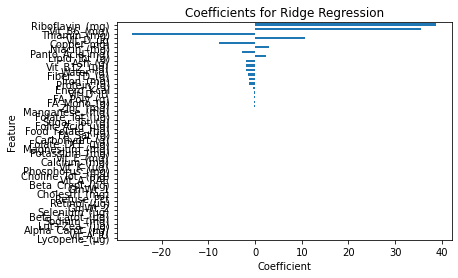

In [14]:
#@title Ridge Model Coefficients
coefficients = model_r.coef_
features = X.columns  # model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

As we can see in the above example, imputing with zeroes did not help our model much at all.

In [15]:
#@title Model Performance Tracking
model_mae_val = []
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val} \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823] 
baseline mae: 12.8257680966969


# III. Experiment #1 - Regression

> Imputing with zeroes is not great for our model ( and discouraged from the documentation ). Let's narrow our dataset with the best data:
---
1.   Drop Constant Columns (Columns with the exact same Value per Row)
2.   Drop Columns missing over 90% of the data (NaN values)
3.   Drop Columns missing over 50% of the data (NaN values)
4.   Drop High Cardinality Categorical Columns (Columns with over 100 different types of values)
5.  Drop all the rows that contain NaN values (because we are taking our full dataset into account and will not impute)





###1.) Wrangle

In [16]:
#@title Wrangle Function #1
def wrangle(data_path):
    df = pd.read_csv(data_path,  
                    index_col= 'NDB_No')  # Set Index (Unique) -- Is a Unique index col still calculated??

    # Drop Constant Columns:
    cons_cols = [col for col in df.columns
                if df[col].nunique() == 1]
    df.drop(columns=cons_cols, inplace=True)
    print("Constant Columns Dropped:", cons_cols)

    # Drop Columns Missing Over 90% of the Data:
    percent_of_data = .10  # adjust this parameter to drop more or less columns...
    empty_threshold = len(df) * percent_of_data
    empty_max_cols = [col for col in df.columns
                        if df[col].isnull().sum() > empty_threshold]
    df.drop(columns=empty_max_cols, inplace=True)
    print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

    # Drop Columns Missing Half of the Data:
    cutoff = int(len(df)/2)
    empty_cols = [col for col in df.columns
                if (df[col].isnull().sum() > cutoff)]
    df.drop(columns=empty_cols, inplace=True)
    print("Columns Dropped with Over Half Missing Values:", empty_cols)

    # Drop HCCCs:
    cutoff = 100
    hcc_cols = [col for col in df.select_dtypes('object').columns
                if df[col].nunique() > cutoff]
    uni_cols = [col for col in df.columns
                if df[col].nunique() == len(df)]
    df.drop(columns= hcc_cols + uni_cols, inplace=True)
    print("High Cardinality Columns Dropped:", hcc_cols, 
            "\nUnique Columns Dropped:", uni_cols)
    
    # Drop Rows that have NaN Values:
    og_rows = len(df)
    df = df.dropna()
    print(og_rows - len(df), 'rows with NaN values dropped!!')

    # Special Drops that are half-empty, HCC, or Unique:
    
    return df

df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: []
2267 rows with NaN values dropped!!


In [17]:
#@title Columns left after Wrangle
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 1001 to 93600
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Water_(g)        6523 non-null   float64
 1   Energ_Kcal       6523 non-null   int64  
 2   Protein_(g)      6523 non-null   float64
 3   Lipid_Tot_(g)    6523 non-null   float64
 4   Ash_(g)          6523 non-null   float64
 5   Carbohydrt_(g)   6523 non-null   float64
 6   Fiber_TD_(g)     6523 non-null   float64
 7   Calcium_(mg)     6523 non-null   float64
 8   Iron_(mg)        6523 non-null   float64
 9   Magnesium_(mg)   6523 non-null   float64
 10  Phosphorus_(mg)  6523 non-null   float64
 11  Potassium_(mg)   6523 non-null   float64
 12  Sodium_(mg)      6523 non-null   float64
 13  Zinc_(mg)        6523 non-null   float64
 14  Vit_C_(mg)       6523 non-null   float64
 15  Thiamin_(mg)     6523 non-null   float64
 16  Riboflavin_(mg)  6523 non-null   float64
 17  Niacin_(mg

In [18]:
#@title Pandas Report: First Wrangle
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###2.) Build Models:

In [19]:
#@title Establish Target [ Vitamin C ] | Train / Test Set | Baseline Model [ MAE ] 
# Establish Target, Prediction Column (X), and y (Drop X)
target = 'Vit_C_(mg)' 
y = df[target]
X = df.drop(columns=target)

# Train / Validation / Test Set
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# Establish Baseline and Calculate Mean Absolute Error (Regression)
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 13.282972880851371


In [20]:
#@title Linear Regression Model

model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

print('Linear Regression Model MAE for training:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('Linear Regression Model for validation:',mean_absolute_error(y_val, model_lr.predict(X_val)) )

Linear Regression Model MAE for training: 14.276920136203733
Linear Regression Model for validation: 16.413444990033526


In [21]:
#@title Standard Ridge Regression Model

model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)

print('Standard Ridge Regression Model MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('Standard Ridge Regression Model MAE for validation',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

Standard Ridge Regression Model MAE for training 14.27141021929458
Standard Ridge Regression Model MAE for validation 16.40799041171919


In [22]:
#@title [To Do: Implement a standard Grid Search]

In [23]:
#@title Ridge Regression Model - Custom Grid Search (Alpha Tune)

# Instantiate Variables
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune, range_max = 1, 100000
factor = 10000  # Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)

# Loop to Build Models
while tune == True:

    # This will train 1000 Models
    for i in range (0,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_r = Ridge(alpha=(i*factor)) 
        model_r.fit(X_train,y_train)

        # Train / Validation MAE
        r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
        r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
        last_mae_val.append(r_mae_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0: ## Printing for big iterations
            print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))

        # Returning the first best alpha
        if r_mae_val < base_mae: 
            best_low_alpha = i*factor
            print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
            tune == False  # Stop Tuning and Return Model

        # FLAG when stats get worse
        if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y':
            best_low_alpha = (i-1)*factor
            print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User Decides to Continue
                if cont.lower().strip() != 'n':
                    tune = True
                
                # If the User Decides to Stop
                else:  
                    best_low_alpha = i*factor
                    print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
                    tune = False
                    break

    # Failsafe to stop the tuning of the model
    if int(i) == range_max-1:
        tune = False
        break

# BEST Ridge Regression Model with Best Alpha
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 14.276920136203659
r_mae_val: 16.413444990033454
last_mae_val: 176.43736855343298
None

LAST MAE VAL HIGHER!! 
 best_low_alpha: 560000
last_mae_val: 13.67951627547677
r_mae_val: 13.67970857786769

Would you like to continue? y/n: n

--FINAL--
best_low_alpha: 570000
last_mae_val: 13.67951627547677
r_mae_val: 13.67970857786769

-- BEST Ridge Model--
best_low_alpha: 570000
r_mae_val:13.67970857786769
base_mae: 13.282972880851371


In [24]:
#@title Ridge Regression Model - Custom Grid Search (Max iterations Tune)

# Instantiate Variables
best_low_iter, last_mae_val, cont = 0, [base_mae**2], 'start'
tune, range_max = 1, 100
factor = 1  # Change in multiples of ten to process Max Iterations faster (.10,1,10,100,etc.)

# Loop to Build Models
while tune == True:

    # This will train 100 models
    for i in range (0,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_r = Ridge(max_iter=(i*factor), alpha=best_low_alpha) # Iterates Max Iterations hyperparameter
        model_r.fit(X_train,y_train)

        # Train / Validation MAE
        r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
        r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
        last_mae_val.append(r_mae_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0:  # Printing for big iterations
            print(print(f"\nI'm Still Running!!\nMax Iterations: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))

        # Returning the first best Max Iterations
        if r_mae_val < base_mae:
            best_low_iter = i*factor
            print(f"\nbest_low_iter: {best_low_iter}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
            tune == False

        # FLAG when stats get worse    
        if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
            best_low_iter = (i-1)*factor
            print(f"\nLAST MAE VAL HIGHER!! \n best_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User Decides to Continue
                if cont.lower().strip() != 'n':
                    tune = True

                # If the User Decides to Stop    
                else:  
                    best_low_iter = i*factor
                    print(f"\n--FINAL--\nbest_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
                    tune = False
                    break

        # Failsafe to stop the tuning of the model
        if int(i) == range_max-1:
            tune = False
            break

# BEST Ridge Regression Model with Best Max Iterations
model_r = Ridge(alpha=(best_low_alpha), max_iter=best_low_iter)
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}\nbest_low_iter: {best_low_iter}")




I'm Still Running!!
Max Iterations: 0
r_mae_train: 11.31656175800777
r_mae_val: 13.67970857786769
last_mae_val: 176.43736855343298
None

-- BEST Ridge Model--
best_low_alpha: 570000
r_mae_val:13.67970857786769
base_mae: 13.282972880851371
best_low_iter: 0


###3.) Evaluate

Index(['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)',
       'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Vit_A_IU', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'Refuse_Pct'],
      dtype='object') 24 = 24


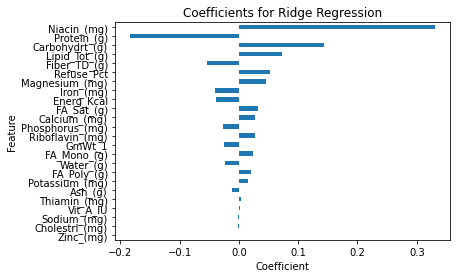

In [25]:
#@title Ridge Model Coefficients
coefficients = model_r.coef_
features = X.columns ## model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [26]:
#@title BEST Features in regards to Prediction Column 
best_feat_cols = ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', target]
print(best_feat_cols)

['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', 'Vit_C_(mg)']


In [27]:
#@title Model Performance Tracking
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823, 13.67970857786769], 
baseline mae: 13.282972880851371


# IV. Experiment #2 - Narrow the Data
> It is possible that we have too many features not very dependent on what we are trying to predict. We will try to reduce the number of columns in our new set and only the top (4) features.


###1.) Wrangle

In [28]:
#@title Wrangle Function #2
def wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Drop Constant Columns
  cons_cols = [col for col in df.columns
              if df[col].nunique() == 1]
  df.drop(columns=cons_cols, inplace=True)
  print("Constant Columns Dropped:", cons_cols)

  ## Drop Columns Missing Over 90% of the Data ##
  percent_of_data = .10 # adjust this parameter to drop more or less columns...
  empty_threshold = len(df) * percent_of_data
  empty_max_cols = [col for col in df.columns
                    if df[col].isnull().sum() > empty_threshold]
  df.drop(columns=empty_max_cols, inplace=True)
  print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

   ## Drop Columns Missing Half of the Data ##
  cutoff = int(len(df)/2)
  empty_cols = [col for col in df.columns
               if (df[col].isnull().sum() > cutoff)]
  df.drop(columns=empty_cols, inplace=True)
  print("Columns Dropped with Over Half Missing Values:", empty_cols)

  ## Drop HCCCs
  cutoff = 100
  hcc_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  uni_cols = [col for col in df.columns
              if df[col].nunique() == len(df)]
  df.drop(columns= hcc_cols + uni_cols, inplace=True)
  print("High Cardinality Columns Dropped:", hcc_cols, 
        "\nUnique Columns Dropped:", uni_cols)
  
  ## Drop Rows that have NaN Values ## -- 
  og_rows = len(df)
  df = df.dropna()
  print(og_rows - len(df), 'rows with NaN values dropped!!')

  #Special Drops that are half-empty, HCC, or Unique:
  not_best_feat_cols = [col for col in df.columns 
                       if col not in best_feat_cols]
  df.drop(columns= not_best_feat_cols, inplace=True)
  print("All But these Columns Dropped:", best_feat_cols)

  return df
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: []
2267 rows with NaN values dropped!!
All But these Columns Dropped: ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', 'Vit_C_(mg)']


In [29]:
#@title Columns left after Wrangle
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 1001 to 93600
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ash_(g)          6523 non-null   float64
 1   Vit_C_(mg)       6523 non-null   float64
 2   Thiamin_(mg)     6523 non-null   float64
 3   Riboflavin_(mg)  6523 non-null   float64
 4   Niacin_(mg)      6523 non-null   float64
dtypes: float64(5)
memory usage: 305.8 KB


In [30]:
#@title Pandas Report: Second Wrangle
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###2.) Build Models:

In [31]:
#@title Establish Target [ Vitamin C ] | Train / Test Set | Baseline Model [ MAE ] 
# Establish Target, Prediction Column (X), and y (Drop X)
target = 'Vit_C_(mg)' 
y = df[target]
X = df.drop(columns=target)

# Train / Validation / Test Set
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# Establish Baseline and Calculate Mean Absolute Error (Regression)
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 13.282972880851371


In [32]:
#@title Linear Regression Model

model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

print('Linear Regression Model MAE for training:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('Linear Regression Model for validation:',mean_absolute_error(y_val, model_lr.predict(X_val)) )

Linear Regression Model MAE for training: 13.825521223972842
Linear Regression Model for validation: 16.128689108858165


In [33]:
#@title Standard Ridge Regression Model

model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)

print('Standard Ridge Regression Model MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('Standard Ridge Regression Model MAE for validation',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

Standard Ridge Regression Model MAE for training 13.820999354886009
Standard Ridge Regression Model MAE for validation 16.123153597894046


In [34]:
#@title [To Do: Implement a standard Grid Search]

In [35]:
#@title Ridge Regression Model - Custom Grid Search (Alpha Tune)

# Instantiate Variables
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune, range_max = 1, 100000
factor = 10000  # Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)

# Loop to Build Models
while tune == True:

    # This will train 1000 Models
    for i in range (0,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_r = Ridge(alpha=(i*factor)) 
        model_r.fit(X_train,y_train)

        # Train / Validation MAE
        r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
        r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
        last_mae_val.append(r_mae_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0: ## Printing for big iterations
            print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))

        # Returning the first best alpha
        if r_mae_val < base_mae: 
            best_low_alpha = i*factor
            print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
            tune == False  # Stop Tuning and Return Model

        # FLAG when stats get worse
        if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y':
            best_low_alpha = (i-1)*factor
            print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User Decides to Continue
                if cont.lower().strip() != 'n':
                    tune = True
                
                # If the User Decides to Stop
                else:  
                    best_low_alpha = i*factor
                    print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
                    tune = False
                    break

    # Failsafe to stop the tuning of the model
    if int(i) == range_max-1:
        tune = False
        break

# BEST Ridge Regression Model with Best Alpha
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 13.825521223972842
r_mae_val: 16.12868910885817
last_mae_val: 176.43736855343298
None

LAST MAE VAL HIGHER!! 
 best_low_alpha: 170000
last_mae_val: 14.71406834688526
r_mae_val: 14.714740467543617

Would you like to continue? y/n: n

--FINAL--
best_low_alpha: 180000
last_mae_val: 14.71406834688526
r_mae_val: 14.714740467543617

-- BEST Ridge Model--
best_low_alpha: 180000
r_mae_val:14.714740467543617
base_mae: 13.282972880851371


In [36]:
#@title Ridge Regression Model - Custom Grid Search (Max iterations Tune)

# Instantiate Variables
best_low_iter, last_mae_val, cont = 0, [base_mae**2], 'start'
tune, range_max = 1, 100
factor = 1  # Change in multiples of ten to process Max Iterations faster (.10,1,10,100,etc.)

# Loop to Build Models
while tune == True:

    # This will train 100 models
    for i in range (0,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_r = Ridge(max_iter=(i*factor), alpha=best_low_alpha) # Iterates Max Iterations hyperparameter
        model_r.fit(X_train,y_train)

        # Train / Validation MAE
        r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
        r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
        last_mae_val.append(r_mae_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0:  # Printing for big iterations
            print(print(f"\nI'm Still Running!!\nMax Iterations: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))

        # Returning the first best Max Iterations
        if r_mae_val < base_mae:
            best_low_iter = i*factor
            print(f"\nbest_low_iter: {best_low_iter}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
            tune == False

        # FLAG when stats get worse    
        if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
            best_low_iter = (i-1)*factor
            print(f"\nLAST MAE VAL HIGHER!! \n best_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User Decides to Continue
                if cont.lower().strip() != 'n':
                    tune = True

                # If the User Decides to Stop    
                else:  
                    best_low_iter = i*factor
                    print(f"\n--FINAL--\nbest_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
                    tune = False
                    break

        # Failsafe to stop the tuning of the model
        if int(i) == range_max-1:
            tune = False
            break

# BEST Ridge Regression Model with Best Max Iterations
model_r = Ridge(alpha=(best_low_alpha), max_iter=best_low_iter)
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}\nbest_low_iter: {best_low_iter}")




I'm Still Running!!
Max Iterations: 0
r_mae_train: 12.43643267319034
r_mae_val: 14.714740467543617
last_mae_val: 176.43736855343298
None

-- BEST Ridge Model--
best_low_alpha: 180000
r_mae_val:14.714740467543617
base_mae: 13.282972880851371
best_low_iter: 0


###3.) Evaluate

Index(['Ash_(g)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)'], dtype='object') 4 = 4


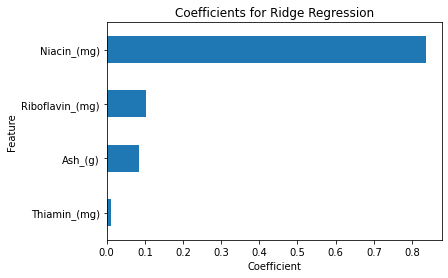

In [37]:
#@title Ridge Model Coefficients
coefficients = model_r.coef_
features = X.columns ## model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [38]:
#@title BEST Features in regards to Prediction Column 
best_feat_cols = ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', target]
print(best_feat_cols)

['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', 'Vit_C_(mg)']


In [39]:
#@title Model Performance Tracking
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823, 13.67970857786769, 14.714740467543617], 
baseline mae: 13.282972880851371


# -- First Thesis / Thoughts: --

> Using Ridge Regression and limiting my features from 25 to 4, I wasn't
able to better my model. My validation mean absolute error in the 
best model was still higher than the baseline (although it did get close).

 Therefore, I am thinking there is little in relation to predicting
 Vitamin C content through any combination of these features. However, I've 
 only been able to use linear and ridge regression.



# I. Re-examining as a Classification Problem - Wrangle Data

> Perhaps by reframing this as a classification problem, we can arrive at a different conclusion. We will try and encode and re-classify the sets
we've done before. Removing as many null values as possible (as per the documentation, this has more to do with recording error)



###1a.) Wrangle

In [40]:
#@title Wrangle Function #3 - Classification

def wrangle(data_path):
    df = pd.read_csv(data_path,  
                    #  index_col= 'NDB_No'  # Set Index (Unique) -- Is a Unique index col still calculated??
                    ) 

    # Drop Constant Columns
    cons_cols = [col for col in df.columns
                if df[col].nunique() == 1]
    df.drop(columns=cons_cols, inplace=True)
    print("Constant Columns Dropped:", cons_cols)

    # Drop Columns Missing Over 90% of the Data
    percent_of_data = .10  # adjust this parameter to drop more or less columns...
    empty_threshold = len(df) * percent_of_data
    empty_max_cols = [col for col in df.columns
                        if df[col].isnull().sum() > empty_threshold]
    df.drop(columns=empty_max_cols, inplace=True)
    print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

        # Drop Columns Missing Half of the Data
    cutoff = int(len(df)/2)
    empty_cols = [col for col in df.columns
                if (df[col].isnull().sum() > cutoff)]
    df.drop(columns=empty_cols, inplace=True)
    print("Columns Dropped with Over Half Missing Values:", empty_cols)

    # Drop HCCCs
    cutoff = 100
    hcc_cols = [col for col in df.select_dtypes('object').columns
                if df[col].nunique() > cutoff]
    uni_cols = [col for col in df.columns
                if df[col].nunique() == len(df)]
    df.drop(columns= hcc_cols + uni_cols, inplace=True)
    print("High Cardinality Columns Dropped:", hcc_cols, 
            "\nUnique Columns Dropped:", uni_cols)
    
    # Drop Rows that have NaN Values
    og_rows = len(df)
    df = df.dropna()
    print(og_rows - len(df), 'rows with NaN values dropped!!')

    # Special Drops that are half-empty, HCC, or Unique:
    # not_best_feat_cols = [col for col in df.columns 
    #                      if col not in best_feat_cols]
    # df.drop(columns= not_best_feat_cols, inplace=True)
    # print("All But these Columns Dropped:", best_feat_cols)

    # Columns that passed previous conditions that should be dropped:
    non_bin = ['Energ_Kcal', 'Refuse_Pct', 'GmWt_1']
    df.drop(columns= non_bin, inplace=True)

    # Manually Encode the Remaining Columns
    content = df > 0
    df.mask(content, other=1, inplace=True)
    df = df.astype(int) ## change to integer
    df = df.astype(bool) ## change to object

    return df
    
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: ['NDB_No']
2267 rows with NaN values dropped!!


###1b.) Manually Encode Columns

> We will manually encode the columns by assuming that any nutrient's content greater than zero will result in a binary classification of 'True' and 'False'  otherwise. This has been masked from integer to boolean within the dataframe.



In [41]:
#@title Columns left after wrangle / encode
print(df.info())
df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 0 to 8789
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Water_(g)        6523 non-null   bool 
 1   Protein_(g)      6523 non-null   bool 
 2   Lipid_Tot_(g)    6523 non-null   bool 
 3   Ash_(g)          6523 non-null   bool 
 4   Carbohydrt_(g)   6523 non-null   bool 
 5   Fiber_TD_(g)     6523 non-null   bool 
 6   Calcium_(mg)     6523 non-null   bool 
 7   Iron_(mg)        6523 non-null   bool 
 8   Magnesium_(mg)   6523 non-null   bool 
 9   Phosphorus_(mg)  6523 non-null   bool 
 10  Potassium_(mg)   6523 non-null   bool 
 11  Sodium_(mg)      6523 non-null   bool 
 12  Zinc_(mg)        6523 non-null   bool 
 13  Vit_C_(mg)       6523 non-null   bool 
 14  Thiamin_(mg)     6523 non-null   bool 
 15  Riboflavin_(mg)  6523 non-null   bool 
 16  Niacin_(mg)      6523 non-null   bool 
 17  Vit_A_IU         6523 non-null   bool 
 18  FA_Sat_(

Water_(g)  Protein_(g)  Lipid_Tot_(g)  Ash_(g)  Carbohydrt_(g)  \
0          True         True           True     True            True   
1          True         True           True     True            True   
2          True         True           True    False           False   
3          True         True           True     True            True   
4          True         True           True     True            True   
...         ...          ...            ...      ...             ...   
8785       True         True           True     True           False   
8786       True         True           True     True            True   
8787       True        False          False     True            True   
8788       True         True           True     True            True   
8789       True         True           True     True           False   

      Fiber_TD_(g)  Calcium_(mg)  Iron_(mg)  Magnesium_(mg)  Phosphorus_(mg)  \
0            False          True       True            True             True   
1            False          True       True            True             True   
2            False          True      False           False             True   
3            False          True       True            True             True   
4            False          True       True            True             True   
...            ...           ...        ...             ...              ...   
8785         False          True       True            True             True   
8786         False          True       True            True             True   
8787         False          True       True            True             True   
8788         False          True       True            True             True   
8789         False          True       True            True             True   

      ...  Zinc_(mg)  Vit_C_(mg)  Thiamin_(mg)  Riboflavin_(mg)  Niacin_(mg)  \
0     ...       True       False          True             True         True   
1     ...       True       False          True             True         True   
2     ...       True       False          True             True         True   
3     ...       True       False          True             True         True   
4     ...       True       False          True             True         True   
...   ...        ...         ...           ...              ...          ...   
8785  ...       True       False          True             True         True   
8786  ...       True       False          True             True         True   
8787  ...       True       False          True             True         True   
8788  ...       True       False          True             True         True   
8789  ...       True       False          True             True         True   

      Vit_A_IU  FA_Sat_(g)  FA_Mono_(g)  FA_Poly_(g)  Cholestrl_(mg)  
0         True        True         True         True            True  
1         True        True         True         True            True  
2         True        True         True         True            True  
3         True        True         True         True            True  
4         True        True         True         True            True  
...        ...         ...          ...          ...             ...  
8785      True        True         True         True            True  
8786      True        True         True         True            True  
8787     False       False        False        False           False  
8788      True        True         True         True            True  
8789      True        True         True         True            True  

[6523 rows x 22 columns]

In [42]:
#@title Pandas Report: First Classification
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###2.) Build Models:

In [43]:
#@title Establish Target [ Vitamin C ] | Train / Test Set | Baseline Model [ MAE ] 
# Establish Target, Prediction Column (X), and y (Drop X)
target = 'Vit_C_(mg)' 
y = df[target]
X = df.drop(columns=target)

# Train / Validation / Test Set
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# Establish Baseline and Calculate Accuracy (Classification)
base_acc = y_train.value_counts(normalize=True).max()
print('baseline accuracy:', base_acc) ## This is the score to beat

baseline accuracy: 0.5331544653123802


In [44]:
#@title Logisitic Regression Model

model_log = make_pipeline(
    LogisticRegression()
)

model_log.fit(X_train, y_train)

model_log_acc = model_log.score(X_train, y_train)
model_log_val = model_log.score(X_val, y_val)

print('Logression Model Training Accuracy:', model_log.score(X_train, y_train))
print('Logression Model Validation Accuracy:', model_log.score(X_val, y_val))

Logression Model Training Accuracy: 0.7736680720582598
Logression Model Validation Accuracy: 0.7800766283524905


In [45]:
#@title Decision Tree Model
model_dt = make_pipeline(
    DecisionTreeClassifier()
)

model_dt.fit(X_train, y_train)

model_dt_acc = model_dt.score(X_train, y_train)
model_dt_val = model_dt.score(X_val, y_val)

print('Decision Tree Model Training Accuracy:',model_dt_acc)
print('Decision Tree Model Validation Accuracy:', model_dt_val)

Decision Tree Model Training Accuracy: 0.7880413951705635
Decision Tree Model Validation Accuracy: 0.7877394636015326


In [46]:
#@title Random Forest Model
model_rf = make_pipeline(
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train)

model_rf_acc = model_rf.score(X_train, y_train)
model_rf_val = model_rf.score(X_val, y_val)

print('Random Forest Model Training Accuracy:', model_rf_acc)
print('Random Forest Model Validation Accuracy:', model_rf_val)

Random Forest Model Training Accuracy: 0.7880413951705635
Random Forest Model Validation Accuracy: 0.7846743295019157


###3a.) Evaluate

In [47]:
#@title Model Performance Tracking
model_acc_val = []
model_acc_val.append("Log: " + str(model_log_acc) + " DT: " + str(model_dt_acc) + " RF: " + str(model_rf_acc))
print(f"model_acc_vals: {model_acc_val}, \nbaseline acc: {base_acc}")

model_acc_vals: ['Log: 0.7736680720582598 DT: 0.7880413951705635 RF: 0.7880413951705635'], 
baseline acc: 0.5331544653123802


In [ ]:
#@title [To Do: Implement a standard Grid Search]

[ 0.81949372 -0.74189722 -0.44784057  0.03371828  1.26416333  0.99213483
  1.32540403 -0.75510519  0.6754824  -0.3373749   0.50027101 -0.41312079
 -0.39403131  0.53604412 -0.18852114  0.84324831  1.61411948  1.17371463
 -0.4908812  -0.293768   -0.59705832]


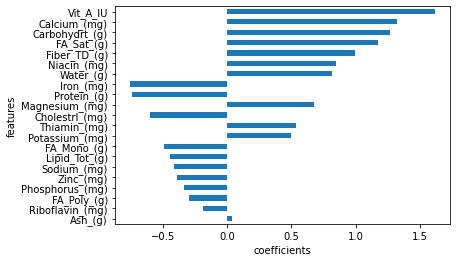

In [48]:
#@title Logisitic Regression Model Coefficients

coefficients = model_log.named_steps['logisticregression'].coef_[0]
print(coefficients)
features = X.columns
pd.Series(data=coefficients, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('coefficients');

In [49]:
#@title Decision Tree Feature Importance

features = X.columns
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

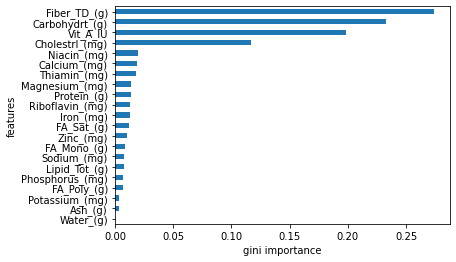

In [50]:
#@title Random Forest Feature Importance
features = X.columns
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

###3b.) Hypertuning

In [51]:
#@title Logisitic Model -- Solver, Penalty (Regularization), and C (Penalty Strength)

print('BASE Logisitic Regression Model Training Accuracy:', model_log.score(X_train, y_train))
print('BASE Logisitic Regression Model Validation Accuracy:', model_log.score(X_val, y_val))

model_log = make_pipeline(
    LogisticRegression(solver='liblinear', penalty='l2', C=10)
)

model_log.fit(X_train, y_train)

model_log_acc = model_log.score(X_train, y_train)
model_log_val = model_log.score(X_val, y_val)

print('TUNED Logisitic Regression Model Training Accuracy:', model_log.score(X_train, y_train))
print('TUNED Logisitic Regression Model Validation Accuracy:', model_log.score(X_val, y_val))

BASE Logisitic Regression Model Training Accuracy: 0.7736680720582598
BASE Logisitic Regression Model Validation Accuracy: 0.7800766283524905
TUNED Logisitic Regression Model Training Accuracy: 0.7736680720582598
TUNED Logisitic Regression Model Validation Accuracy: 0.7816091954022989


In [52]:
#@title Decision Tree -- Max Depth (of Tree)

print('BASE Decision Tree Model Training Accuracy:',model_dt_acc)
print('BASE Decision Tree Model Validation Accuracy:', model_dt_val)

model_dt = make_pipeline(
    DecisionTreeClassifier(max_depth= 50)
)

model_dt.fit(X_train, y_train)

model_dt_acc = model_dt.score(X_train, y_train)
model_dt_val = model_dt.score(X_val, y_val)

print('TUNED Decision Tree Model Training Accuracy:',model_dt_acc)
print('TUNED Decision Tree Model Validation Accuracy:', model_dt_val)

BASE Decision Tree Model Training Accuracy: 0.7880413951705635
BASE Decision Tree Model Validation Accuracy: 0.7877394636015326
TUNED Decision Tree Model Training Accuracy: 0.7880413951705635
TUNED Decision Tree Model Validation Accuracy: 0.7862068965517242


In [54]:
#@title Random Forest - Custom Grid Search (Max Features, Max Depth, and n_estimators)

print('RANDOM FOREST: Training Accuracy:', model_rf_acc)
print('RANDOM FOREST: Validation Accuracy:', model_rf_val)

best_max_depth = []

# Max Depths TUNE
best_max_depth, last_acc_val, cont = 0, [base_acc], 'start'
tune, range_max = 1, 40
factor = 1  # Change in multiples of ten to process hyperparameter faster (.10,1,10,100,etc.)

# Loop to Build Model
while tune == True:

    # This will return 40 models...
    for i in range (1,range_max):

        # Instantiate and Fit Model with i as the variable Alpha
        model_rf = RandomForestClassifier(max_depth=(i*factor))  # Iterates Max Depth hyperparameter
        model_rf.fit(X_train,y_train)

        # Train / Validation MAE
        model_rf_acc = model_rf.score(X_train, y_train)
        model_rf_val = model_rf.score(X_val, y_val)
        last_acc_val.append(model_rf_val)

        # Within Factors of 10, show that the computation is still running...
        if (i % (1000)) == 0:  # Printing for big iterations
            print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {model_rf_acc}\nmodel_rf_val: {model_rf_val}\nlast_acc_val: {last_acc_val[-2]}"))

        # FLAG when the model gets worse
        if model_rf_val < last_acc_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y':
            best_max_depth = (i-1)*factor
            print(f"\nLAST ACC VAL HIGHER!! \n best_max_depth: {best_max_depth}\nlast_acc_val: {last_acc_val[-2]}\nmodel_rf_val: {model_rf_val}")
            tune = False

            # Ask the User if they would like to continue anyways
            if tune == False and cont.lower().strip() != 'y':
                cont = input("\nWould you like to continue? y/n: ")

                # If the User decides to Stop
                if cont.lower().strip() != 'n':
                    tune = True

                # If the user decides to continue  
                else:  
                    best_max_depth = i*factor
                    print(f"\n--FINAL--\nbest_max_depth: {best_max_depth}\nlast_acc_val: {last_acc_val[-2]}\nmodel_rf_val: {model_rf_val}")
                    tune = False
                    break

        # Failsafe to stop the tuning of the model     
        if int(i) == range_max-1:
            tune = False
            break

# BEST Random Forest Model with Best Max Depth
model_rf = make_pipeline(
    RandomForestClassifier(max_depth=(best_max_depth))
    )
model_rf.fit(X_train,y_train)
model_rf_acc = model_rf.score(X_train, y_train)
model_rf_val = model_rf.score(X_val, y_val)
print(f"\n-- BEST Random Forest Model--\nbest_max_depth: {best_max_depth}\nmodel_rf_val:" 
    f"{model_rf_val}\nbase_acc: {base_acc}")

RANDOM FOREST: Training Accuracy: 0.7880413951705635
RANDOM FOREST: Validation Accuracy: 0.7846743295019157

LAST ACC VAL HIGHER!! 
 best_max_depth: 5
last_acc_val: 0.7862068965517242
model_rf_val: 0.7839080459770115

Would you like to continue? y/n: n

--FINAL--
best_max_depth: 6
last_acc_val: 0.7862068965517242
model_rf_val: 0.7839080459770115

-- BEST Random Forest Model--
best_max_depth: 6
model_rf_val:0.7885057471264367
base_acc: 0.5331544653123802


In [55]:
#@title Tuned Logisitic Regression Model Coefficients
coefficients = model_log.named_steps['logisticregression'].coef_[0]
features = X.columns
pd.Series(data=coefficients, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('coefficients');


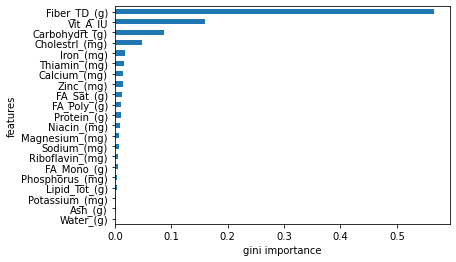

In [56]:
#@title Tuned Decision Tree Feature Importance

features = X.columns
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

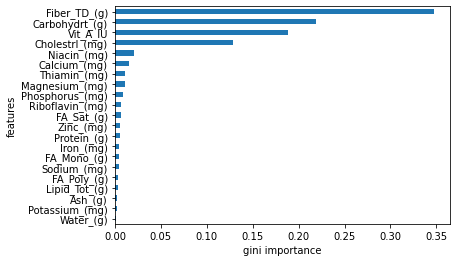

In [57]:
#@title Tuned Random Forest Feature Importance
features = X.columns
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

###3c.) Visualize Predicitions

In [ ]:
## Decision Tree -- Max Depth (of Tree) ##
# model_dt_acc = model_dt.score(X_train, y_train)
# model_dt_val = model_dt.score(X_val, y_val)
# model_dt_test = model_dt.predict(X_test)
# print('Tuned TREE: Training Accuracy:',model_dt_acc)
# print('Tuned TREE: Validation Accuracy:', model_dt_val)